In [1]:
import numpy as np
import h5py
import string
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import time
import glob
from util import crawl_meta, PaperMeta, Keyword
%matplotlib inline

In [2]:
CRAWL_DATA = False
AFTER_DECISION = False
CRAWL_REVIEW = False

In [3]:
# Get the meta data
if CRAWL_DATA:
    # Uncomment this if you want to crawl data from scratch
    meta_list = crawl_meta(
        meta_hdf5=None, 
        write_meta_name='data_{}.hdf5'.format(time.strftime("%Y%m%d%H%M%S")), 
        crawl_review=CRAWL_REVIEW)
else:
    # Uncomment this if you want to load the previously stored data file
    meta_hdf5s = glob.glob("*.hdf5")
    meta_hdf5 = sorted(meta_hdf5s)[-1] # the most recent data
    print("Loading {} ...".format(meta_hdf5))
    meta_list = crawl_meta(meta_hdf5=meta_hdf5)
num_withdrawn = len([m for m in meta_list if m.withdrawn or m.desk_reject])
print('Number of submissions: {} (withdrawn/desk reject submissions: {})'.format(
    len(meta_list), num_withdrawn))

Loading data_20191114111500.hdf5 ...


/home/walter/ENV/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Number of submissions: 2594 (withdrawn/desk reject submissions: 230)


In [4]:
rating = []
rating_mean = []
num_rating = []
keywords = []
for m in meta_list:
    rating.extend(m.rating)
    keywords.extend(m.keyword)
    if not (m.withdrawn or m.desk_reject):
        num_rating.append(len(m.rating))
    if len(m.rating) > 0:
        rating_mean.append(m.average_rating)
print('Average rating: {:.4f}'.format(np.mean(rating)))

Average rating: 3.9494


/home/walter/ENV/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  
/home/walter/ENV/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.


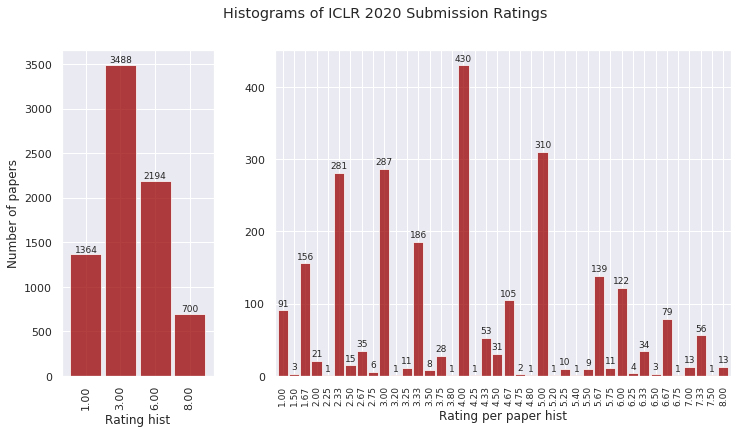

In [5]:
# Plot histograms of ratings
from collections import Counter
from matplotlib import gridspec
import seaborn as sns; sns.set()
fig = plt.figure(figsize=(12, 6))
plt.suptitle('Histograms of ICLR 2020 Submission Ratings')

# Rating hist
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
counterlist =  sorted(Counter(rating).most_common())
frequencies = [k[1] for k in counterlist]
bins = [k[0] for k in counterlist]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['{:.2f}'.format(b) for b in bins]

ax1 = freq_series.plot(kind='bar', color='#990000', alpha=0.75, width=0.9)
ax1.set_xlabel('Rating hist')
ax1.set_ylabel('Number of papers')
ax1.set_xticklabels(x_labels)

rects = ax1.patches
labels = [int(frequencies[i]) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', fontsize=9)

# Rating per paper hist
plt.subplot(gs[1])
counterlist =  sorted(Counter(rating_mean).most_common())
frequencies = [k[1] for k in counterlist]
bins = [k[0] for k in counterlist]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['{:.2f}'.format(b) for b in bins]

ax2 = freq_series.plot(kind='bar', color='#990000', alpha=0.75, width=0.9)
ax2.set_xlabel('Rating per paper hist')
ax2.set_xticklabels(x_labels, fontsize=9)

rects = ax2.patches
labels = [int(frequencies[i]) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width() / 2, height + 3, label,
            ha='center', va='bottom', fontsize=9)
plt.show()
fig.savefig('asset/rating.png')

In [6]:
# See how many papers are beaten by yours
def PR(rating_mean, your_rating):
    pr = np.sum(your_rating > np.array(rating_mean))/len(rating_mean)*100
    same_rating = np.sum(your_rating == np.array(rating_mean))/len(rating_mean)*100    
    return pr, same_rating
my_rating = (6+6+3)/3.  # your average rating here
pr, same_rating = PR(rating_mean, my_rating)
print('Your papar ({:.2f}) beats {:.2f}% of submissions based on the ratings. '
      '({:.2f}% with the same rating)'.format(
          my_rating, pr, same_rating))

#            accept rate       orals     posters
# ICLR 2017: 39.1% (198/507)    15         183
# ICLR 2018: 32.0% (314/981)    23         291
# ICLR 2019: 31.4% (500/1591)   24         476
# ICLR 2020: ?     (?/2594)

Your papar (5.00) beats 68.49% of submissions based on the ratings. (12.10% with the same rating)


In [7]:
# Count keywords
keywords_hist = Counter(keywords)
del keywords_hist['']
print('{} different keywords before merging'.format(len(keywords_hist)))

# Merge duplicates: CNNs and CNN
duplicates = []
for k in keywords_hist:
    if k+'s' in keywords_hist:
        duplicates.append(k)
for k in duplicates:
    keywords_hist[k] += keywords_hist[k+'s']
    del keywords_hist[k+'s']
print('{} different keywords after merging'.format(len(keywords_hist)))

4127 different keywords before merging
3993 different keywords after merging


In [8]:
# Create keywords list
keywords_list = []
keywords_key_list = []
for m in meta_list:
    for k in [mk for mk in m.keyword if not mk == '']:
        if k not in keywords_hist.keys():
            k = k[:-1]  # strip 's'
        if k in keywords_key_list:
            idx = keywords_key_list.index(k)
            keywords_list[idx].update_frequency(1)
            keywords_list[idx].update_rating(m.rating)
        else:
            # the keyword is new to the list
            k_object = Keyword(k, 1, m.rating)
            keywords_list.append(k_object)
            keywords_key_list.append(k_object.keyword)

107


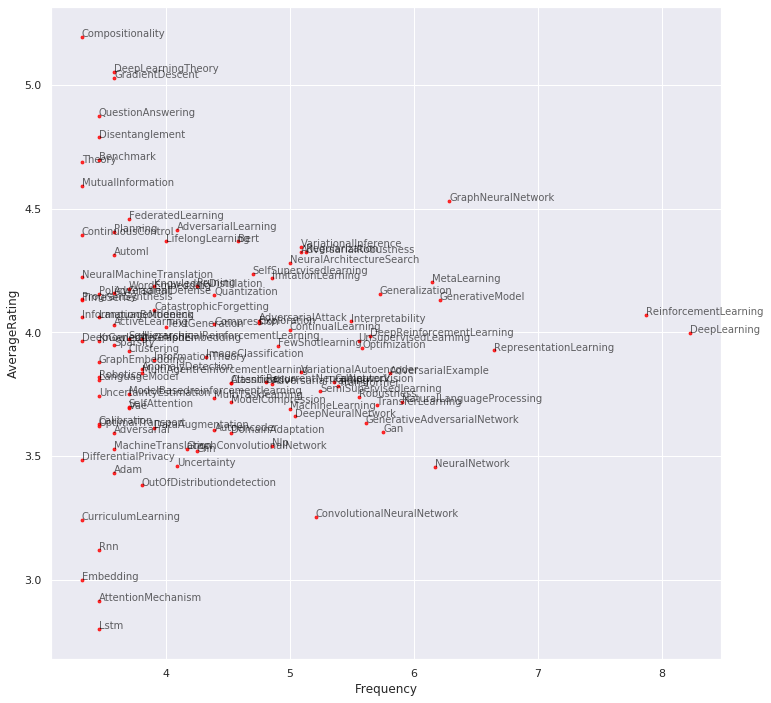

In [9]:
keywords_list_subset = [k for k in keywords_list if k.frequency > 9]
print(len(keywords_list_subset))
y = [k.average_rating() for k in keywords_list_subset]
x = [np.log2(k.frequency) for k in keywords_list_subset]
key = [k.keyword for k in keywords_list_subset]

# Create dataframe
df = pd.DataFrame({
    'Frequency': x,
    'AverageRating': y,
    'Keyword': key
})

sns.set(font_scale=1)
fig = plt.figure(figsize=(12, 12))
p1 = sns.regplot(data=df, x="Frequency", y="AverageRating", fit_reg=False, 
                 marker="o", color="red", logx=True, scatter_kws={'s': 8})
for line in range(0, df.shape[0]):
     p1.text(df.Frequency[line], df.AverageRating[line], df.Keyword[line], 
             horizontalalignment='left', 
             size='small', color='black', alpha=0.6)
plt.show()
fig.savefig('asset/rating_frequency.png')

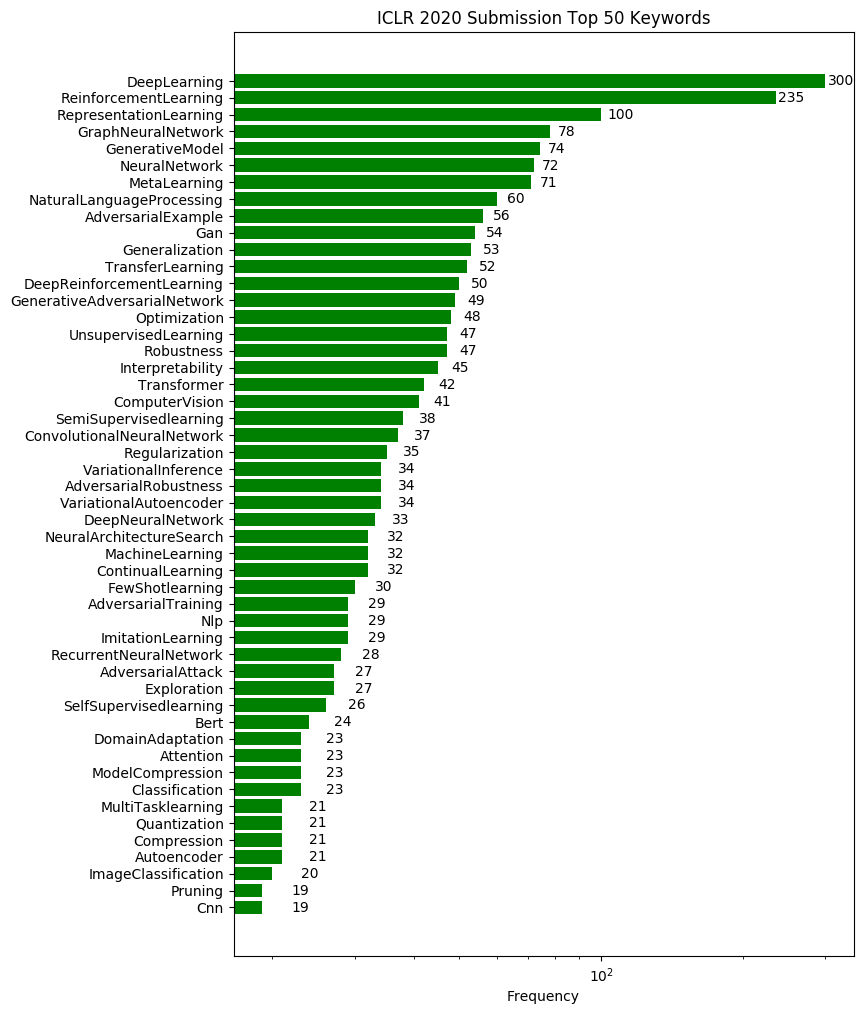

In [10]:
# Show N most common keywords and their frequencies
num_keyowrd = 50
keywords_hist_vis = keywords_hist.most_common(num_keyowrd)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 12))

key = [k[0] for k in keywords_hist_vis] 
value = [k[1] for k in keywords_hist_vis] 
y_pos = np.arange(len(key))
ax.barh(y_pos, value, align='center', color='green', ecolor='black', log=True)
ax.set_yticks(y_pos)
ax.set_yticklabels(key, rotation=0, fontsize=10)
ax.invert_yaxis() 
for i, v in enumerate(value):
    ax.text(v + 3, i + .25, str(v), color='black', fontsize=10)
# ax.text(y_pos, value, str(value))
ax.set_xlabel('Frequency')
ax.set_title('ICLR 2020 Submission Top {} Keywords'.format(num_keyowrd))

plt.show()
fig.savefig('asset/frequency.png')

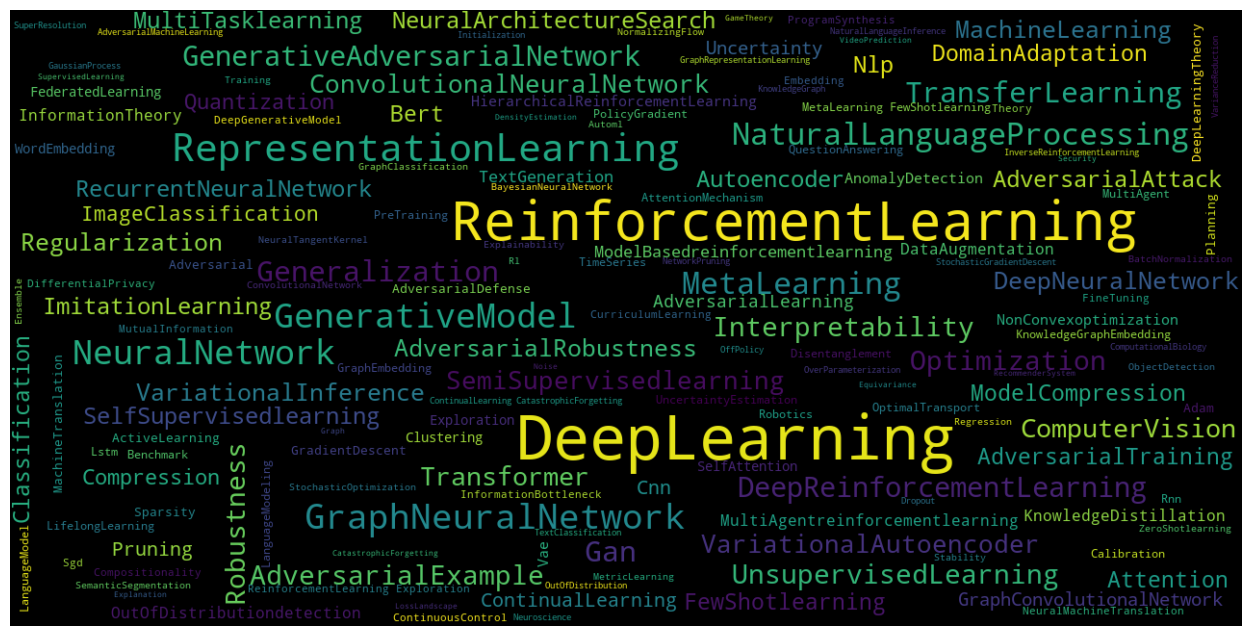

In [11]:
# Show the word cloud forming by keywords
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=64, max_words=160, 
                      width=1280, height=640,
                      background_color="black").generate(' '.join(keywords))
fig = plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
fig.savefig('asset/wordcloud.png')

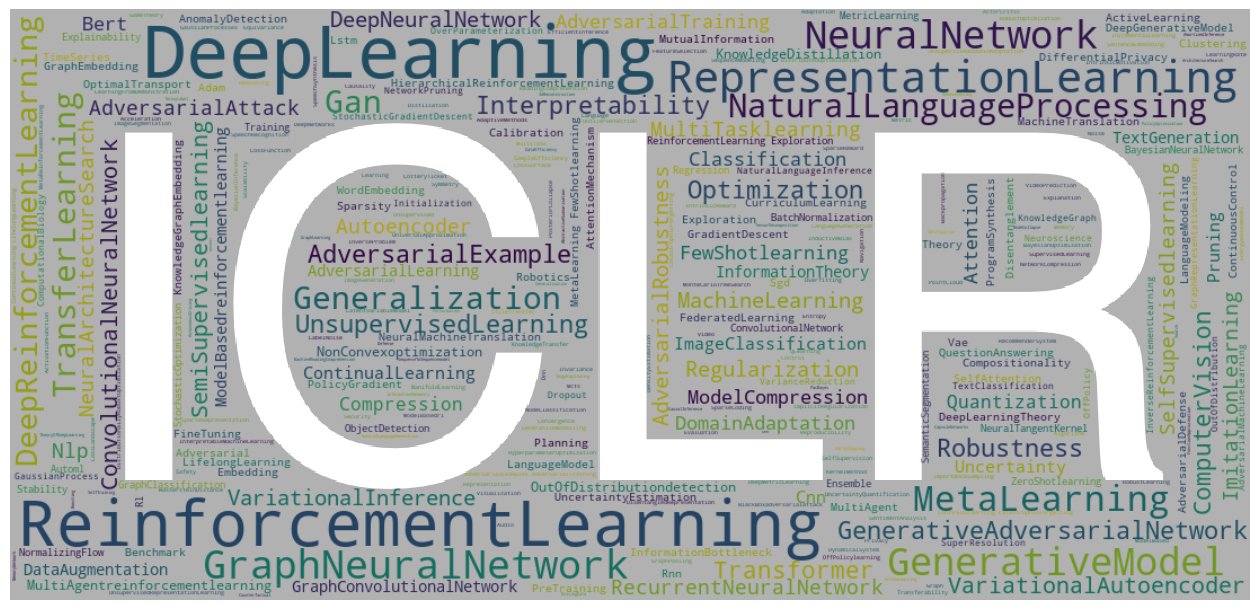

In [12]:
# Show the word cloud with an ICLR logo
from imageio import imread
logo = imread('asset/logo.png')
wordcloud = WordCloud(max_font_size=64, max_words=300, 
                      width=1280, height=640,
                      background_color="white", mask=logo).generate(' '.join(keywords))
fig = plt.figure(figsize=(16, 8), frameon=False)
plt.imshow(logo)
plt.imshow(wordcloud, interpolation="bilinear",  alpha=.7)
plt.axis("off")
plt.show()
fig.savefig('asset/logo_wordcloud.png')

In [13]:
num_valid = len(meta_list) - num_withdrawn
num_missing_rating = num_valid*3 - np.sum(np.clip(num_rating, 0, 3))
print('Number of missing reviews: {} ({:.4f}%)'.format(
    num_missing_rating, 100*float(num_missing_rating)/(num_valid*3)))

Number of missing reviews: 102 (1.4382%)


In [14]:
import operator
meta_list_sorted_review_len_min = sorted(
    [m for m in meta_list if not m.review_len_min is None], 
    key=operator.attrgetter('review_len_min'))
meta_list_sorted_review_len_max = sorted(
    [m for m in meta_list if not m.review_len_max is None], 
    key=operator.attrgetter('review_len_max'), reverse=True)

In [15]:
TOP_NUM = 10
print('[Shortest reviews]')
for m in meta_list_sorted_review_len_min[:TOP_NUM]:
    print('{} words: {} {}'.format(m.review_len_min, m.url, m.title))
print('[Longest reviews]')    
for m in meta_list_sorted_review_len_max[:TOP_NUM]:
    print('{} words: {} {}'.format(m.review_len_max, m.url, m.title))        

[Shortest reviews]
14 words: https://openreview.net/forum?id=H1eH9hNtwr Stagnant Zone Segmentation With U-net
17 words: https://openreview.net/forum?id=BkluqlSFDS Federated Learning With Matched Averaging
17 words: https://openreview.net/forum?id=HyloPnEKPr Context-aware Attention Model For Coreference Resolution
27 words: https://openreview.net/forum?id=Bkxe2AVtPS Shifted And Squeezed 8-bit Floating Point Format For Low-precision Training Of Deep Neural Networks
33 words: https://openreview.net/forum?id=HJxcP2EFDS Amharic Negation Handling
51 words: https://openreview.net/forum?id=SyxQh3EFDr Hierarchical Complement Objective Training
56 words: https://openreview.net/forum?id=S1gR2ANFvB Model Comparison Of Beer Data Classification Using An Electronic Nose
63 words: https://openreview.net/forum?id=HylwpREtDr Active Learning Graph Neural Networks Via Node Feature Propagation
70 words: https://openreview.net/forum?id=Sklyn6EYvH Disentangled Representation Learning With Sequential Residual

In [16]:
# average review len
all_rating = []
all_review_len = []
for m in meta_list:
    if len(m.review_len) > 0:
        all_rating.extend(m.rating)
        all_review_len.extend(m.review_len)        
print('The average review length: {:.2f} words'.format(np.mean(all_review_len)))
all_review_len_sorted_clip = sorted(all_review_len)[10:-10]

The average review length: 395.99 words


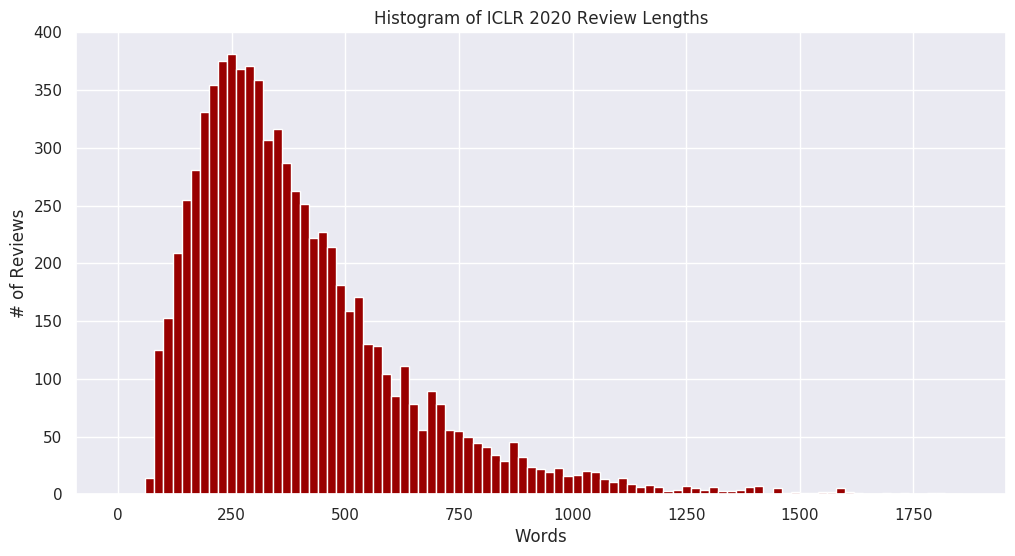

In [17]:
# Plot histograms of ratings
sns.set()
fig = plt.figure(figsize=(12, 6))
plt.title('Histogram of ICLR 2020 Review Lengths')

# Review length hist
interval = 20
plt.hist(all_review_len_sorted_clip, bins=[v*interval for v in list(
    np.array(range(np.max(all_review_len_sorted_clip)//interval)))],
    color='#990000')
plt.xlabel('Words')
plt.ylabel('# of Reviews')
plt.show()
fig.savefig('asset/review_len_hist.png')

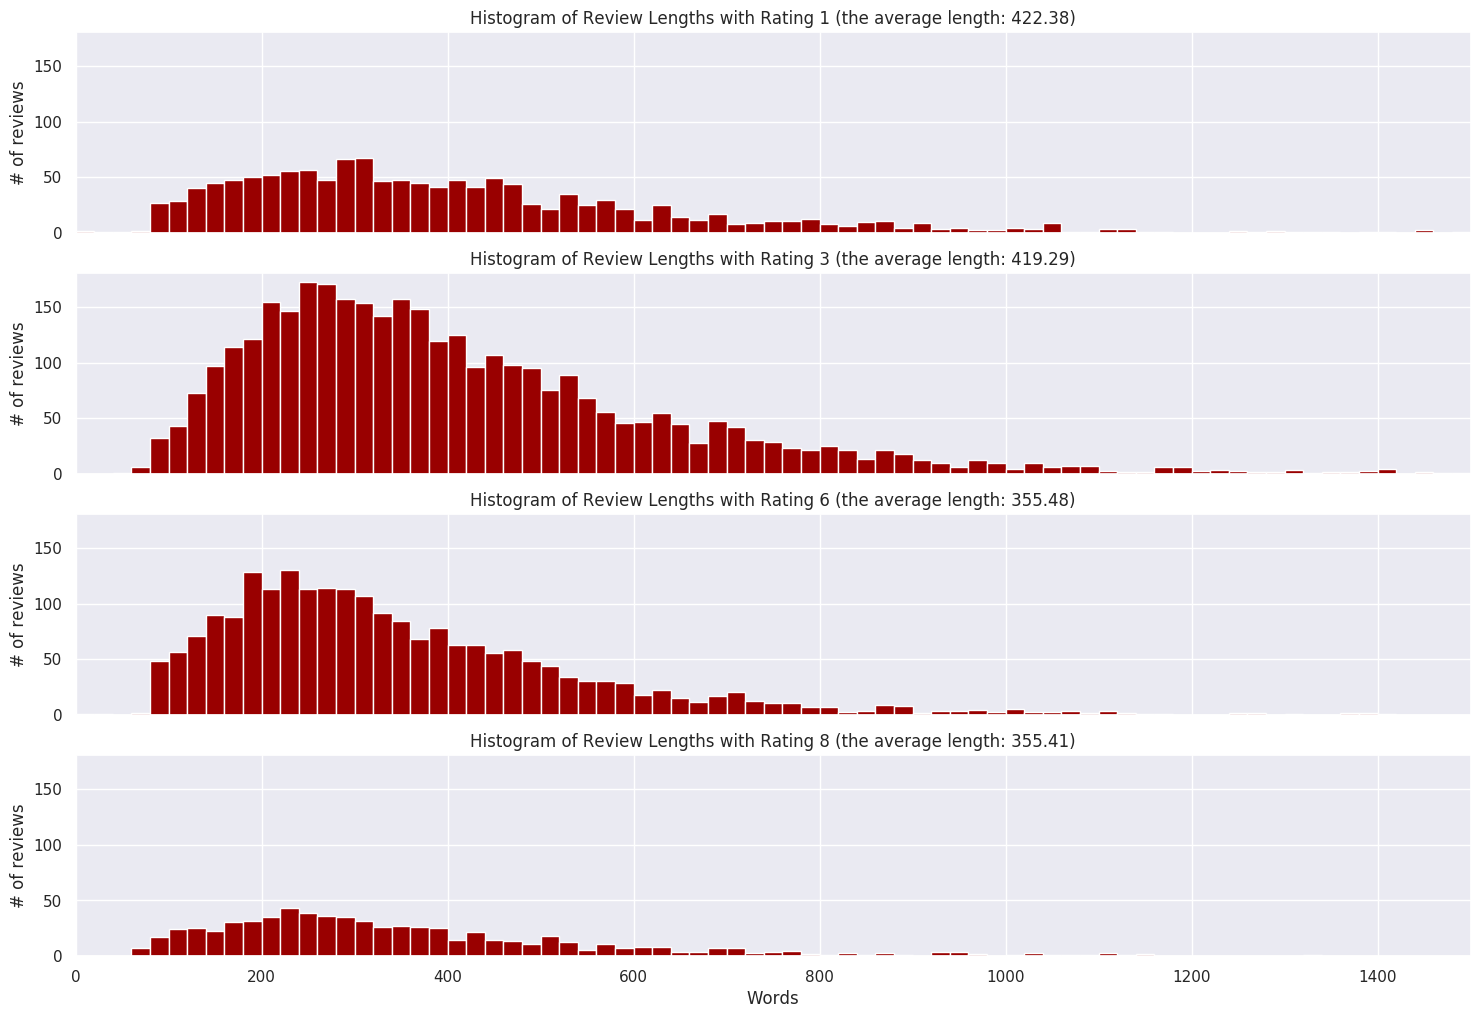

In [18]:
unique_ratings = np.unique(all_rating)
bins = [v*interval for v in list(np.array(range(np.max(all_review_len)//interval)))]
gs = gridspec.GridSpec(4, 1) 
fig = plt.figure(figsize=(18, 12))
for i, unique_rating in enumerate(unique_ratings):
    plt.subplot(gs[i])
    # Plot histograms of ratings
    
    # Review length hist
    all_review_len_rating = []
    for j, r in enumerate(all_rating):
        if r == unique_rating:
            all_review_len_rating.append(all_review_len[j])
            
    plt.title('Histogram of Review Lengths with Rating {} (the average length: {:.2f})'.format(
        unique_rating, np.mean(all_review_len_rating)))
    
    plt.hist(all_review_len_rating, bins=bins, color='#990000')
    if i == len(unique_ratings)-1:
        plt.xlabel('Words')
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off    
    plt.ylim(0, 180)
    plt.xlim(0, 1500)     
    plt.ylabel('# of reviews')      
plt.show()    
fig.savefig('asset/review_len_hist_rating.png')

In [19]:
# the papers that don't have 3 reviews
count = 0
for m in meta_list:
    if len(m.rating) < 3 and not (m.withdrawn or m.desk_reject):
        count += 1
        print('[{}] {} {} {}'.format(count, m.title, m.url, m.rating))

[1] On Weight-sharing And Bilevel Optimization In Architecture Search https://openreview.net/forum?id=HJgRCyHFDr [3 3]
[2] Pretraining Boosts Out-of-domain Robustness For Pose Estimation https://openreview.net/forum?id=BkgMbCVFvr [1 1]
[3] A Theory Of Usable Information Under Computational Constraints https://openreview.net/forum?id=r1eBeyHFDH [8 8]
[4] Retrospection: Leveraging The Past For Efficient Training Of Deep Neural Networks https://openreview.net/forum?id=H1eY00VFDB [3 6]
[5] Deep Expectation-maximization In Hidden Markov Models Via Simultaneous Perturbation Stochastic Approximation https://openreview.net/forum?id=BkxGAREYwB [3 3]
[6] Consistency-based Semi-supervised Active Learning: Towards Minimizing Labeling Budget https://openreview.net/forum?id=HJl8SkBYPr [6 6]
[7] Prototype-assisted Adversarial Learning For Unsupervised Domain Adaptation https://openreview.net/forum?id=Byg79h4tvB [6 3]
[8] Sub-policy Adaptation For Hierarchical Reinforcement Learning https://openreview

In [20]:
# high variance (both 1 and 8 but not 3 or 6)
count = 0
for m in meta_list:
    if 1 in m.rating and 8 in m.rating and 6 not in m.rating and 3 not in m.rating:
        count += 1
        print('[{}] {} {} {}'.format(count, m.title, m.url, m.rating))

[1] Nas Evaluation Is Frustratingly Hard https://openreview.net/forum?id=HygrdpVKvr [8 8 1]
[2] Varibad: A Very Good Method For Bayes-adaptive Deep Rl Via Meta-learning https://openreview.net/forum?id=Hkl9JlBYvr [8 1 8 1]
[3] Confidence Scores Make Instance-dependent Label-noise Learning Possible https://openreview.net/forum?id=SyevDaVYwr [8 1 8]
[4] Nas-bench-1shot1: Benchmarking And Dissecting One-shot Neural Architecture Search https://openreview.net/forum?id=SJx9ngStPH [8 8 1]
[5] Padé Activation Units: End-to-end Learning Of Flexible Activation Functions In Deep Networks https://openreview.net/forum?id=BJlBSkHtDS [1 8 1]
[6] Accelerating Reinforcement Learning Through Gpu Atari Emulation https://openreview.net/forum?id=HJgS7p4FPH [8 1 8]
[7] Angular Visual Hardness https://openreview.net/forum?id=HkxJHlrFvr [8 8 1]
[8] Learn Interpretable Word Embeddings Efficiently With Von Mises-fisher Distribution https://openreview.net/forum?id=Bke02gHYwB [1 8 1]


In [21]:
# Write all the data to README
import datetime
with open('README.md', 'r+') as readme:
    lines = readme.readlines()

data_title = '## <a id="Data"></a>All ICLR 2020 OpenReview data\n'
idx = lines.index(data_title)
lines = lines[:idx]

with open('README.md', 'w') as readme:
    for line in lines:
        readme.write(line)
    readme.write(data_title)
    readme.write('Collected at {}\n\n'.format(datetime.datetime.now()))
    readme.write('Number of submissions: {} (withdrawn/desk reject submissions: {})\n\n'.format(
        len(meta_list), num_withdrawn))
    readme.write('| Rank | Average Rating | Title | Ratings | Variance | Decision |\n')
    readme.write('| --- | --- | --- | --- | --- | --- |\n')
    non_empty_rating_meta_list = [m for m in meta_list if not len(m.rating)==0]
    empty_rating_meta_list = [m for m in meta_list if len(m.rating)==0]    
    sorted_idx = np.argsort([np.mean(m.rating) for m in non_empty_rating_meta_list])[::-1]
    for i, idx in enumerate(sorted_idx):
        m = non_empty_rating_meta_list[idx]
        readme.write('| {} | {:.2f} | [{}]({}) | {} | {:.2f} | {} |\n'.format(
            i+1, np.mean(m.rating), 
            m.title if not (m.withdrawn or m.desk_reject) else '~~'+m.title+'~~',  
            m.url, ', '.join([str(r) for r in list(m.rating)]),
            np.std(m.rating), m.decision
        ))
    for i, m in enumerate(empty_rating_meta_list):
        readme.write('| {} | {:.2f} | [{}]({}) | {} | {:.2f} | {} |\n'.format(
            i+1+len(non_empty_rating_meta_list), np.mean(m.rating), 
            m.title if not (m.withdrawn or m.desk_reject) else '~~'+m.title+'~~',
            m.url, ', '.join([str(r) for r in list(m.rating)]),
            np.std(m.rating), m.decision
        ))

/home/walter/ENV/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/walter/ENV/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/walter/ENV/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/walter/ENV/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/walter/ENV/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
if AFTER_DECISION:
    rating_mean_accept = []
    rating_mean_reject = []
    for m in meta_list:
        if len(m.rating) > 0:
            if 'Accept' in m.decision:
                rating_mean_accept.append(m.average_rating)
            else:
                rating_mean_reject.append(m.average_rating)
    print('Average rating of accepted papers: {}'.format(np.mean(rating_mean_accept)))
    print('Average rating of rejected papers: {}'.format(np.mean(rating_mean_reject)))

In [23]:
if AFTER_DECISION:
    fig = plt.figure(figsize=(12, 7))
    plt.title('Histograms of ICLR 2020 Submission Ratings', fontsize=15)

    # accepted
    counterlist_all = sorted(Counter(rating_mean).most_common())
    counterlist_accept =  sorted(Counter(rating_mean_accept).most_common())
    for c in counterlist_all:
        if c[0] not in [ca[0] for ca in counterlist_accept]:
            counterlist_accept.append((c[0], 0))
    counterlist_accept = sorted(counterlist_accept)
    frequencies = [k[1] for k in counterlist_accept]
    freq_series = pd.Series.from_array(frequencies)
    bins = [k[0] for k in counterlist_all]

    x_labels = ['{:.2f}'.format(b) for b in bins]

    ax1 = freq_series.plot(kind='bar', color='#990000', alpha=0.5, width=0.9)

    rects = ax1.patches
    labels = [int(frequencies[i]) for i in range(len(rects))]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        if label > 0:
            ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, label,
                     ha='center', va='bottom', fontsize=9, color='#990000')

    # rejected
    counterlist_reject =  sorted(Counter(rating_mean_reject).most_common())
    for c in counterlist_all:
        if c[0] not in [ca[0] for ca in counterlist_reject]:
            counterlist_reject.append((c[0], 0))
    counterlist_reject = sorted(counterlist_reject)
    frequencies = [k[1] for k in counterlist_reject]
    freq_series = pd.Series.from_array(frequencies)

    ax2 = freq_series.plot(kind='bar', color='#000099', alpha=0.5, width=0.9)
    ax2.set_xlabel('Rating per paper hist', fontsize=15)
    ax2.set_ylabel('Number of papers', fontsize=15)
    ax2.set_xticklabels(x_labels, fontsize=9)

    rects = ax2.patches[int(len(rects)/2):]
    labels = [int(frequencies[i]) for i in range(len(rects))]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        if label > 0:
            ax2.text(rect.get_x() + rect.get_width() / 2, height + 2, label,
                     ha='center', va='bottom', fontsize=9, color='#000099')

    ax1.legend(('Accepted Papers', 'Rejected Papers'), fontsize=15)
    plt.show()
    fig.savefig('asset/decision.png')

In [24]:
# Compare data crawled at different time
from collections import Counter
data1 = 'data_20191105041300.hdf5'
data2 = 'data_20191114111500.hdf5'

def get_rating(filename):
    print('Loading {} ...'.format(filename))
    meta_list = crawl_meta(meta_hdf5=filename)    
    rating = []    
    rating_mean = []
    for m in meta_list:
        rating.extend(m.rating)
        if len(m.rating) > 0:
            rating_mean.append(m.average_rating)
    print('Average rating: {:.4f}'.format(np.mean(rating)))    
    
    crawl_time = time.strftime(
        '%m/%d/%Y %I:%M:%S %p', 
        time.strptime(filename.split('_')[-1].split('.')[0], '%Y%m%d%H%M%S'))
    return rating_mean, rating, crawl_time

rating_mean_1, rating_1, time1 = get_rating(data1)
rating_mean_2, rating_2, time2 = get_rating(data2)

Loading data_20191105041300.hdf5 ...


/home/walter/ENV/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Average rating: 3.9071
Loading data_20191114111500.hdf5 ...
Average rating: 3.9494


In [25]:
def distribution_differet_plot(
        data1, data2, name, xlabel, ylabel, figname=None,
        legend_distance=0.5, legend_height_offset=1,
    ):
    fig = plt.figure(figsize=(15, 7))
    plt.title(name, fontsize=15)


    # data1
    counterlist_all = sorted(Counter(data1['data']+data2['data']).most_common())
    counterlist2 =  sorted(Counter(data1['data']).most_common())
    for c in counterlist_all:
        if c[0] not in [ca[0] for ca in counterlist2]:
            counterlist2.append((c[0], 0))
    counterlist2 = sorted(counterlist2)
    frequencies = [k[1] for k in counterlist2]
    frequencies_normalized = [float(f) / np.sum(frequencies) * 100 for f in frequencies]
    freq_series = pd.Series.from_array(frequencies_normalized)
    bins = [k[0] for k in counterlist_all]

    x_labels = ['{:.2f}'.format(b) for b in bins]

    ax1 = freq_series.plot(kind='bar', color='#990000', alpha=0.25, width=0.9)

    rects = ax1.patches
    labels = ['{:.1f}'.format(frequencies_normalized[i]) for i in range(len(rects))]    

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        if float(label) > 0:
            ax1.text(rect.get_x() + rect.get_width() / 2 - legend_distance, 
                     height + legend_height_offset, label,
                     ha='center', va='bottom', fontsize=9, color='#990000')

    # data2
    counterlist2 =  sorted(Counter(data2['data']).most_common())
    for c in counterlist_all:
        if c[0] not in [ca[0] for ca in counterlist2]:
            counterlist2.append((c[0], 0))
    counterlist2 = sorted(counterlist2)
    frequencies = [k[1] for k in counterlist2]
    frequencies_normalized = [float(f) / np.sum(frequencies) * 100 for f in frequencies]
    freq_series = pd.Series.from_array(frequencies_normalized)

    ax2 = freq_series.plot(kind='bar', color='#000099', alpha=0.25, width=0.9)
    ax2.set_xlabel(xlabel, fontsize=15)
    ax2.set_ylabel(ylabel, fontsize=15)
    ax2.set_xticklabels(x_labels, fontsize=9)

    rects = ax2.patches[int(len(rects)/2):]
    labels = ['{:.1f}'.format(frequencies_normalized[i]) for i in range(len(rects))]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        if float(label) > 0:
            ax2.text(rect.get_x() + rect.get_width() / 2 + legend_distance, 
                     height + legend_height_offset, label,
                     ha='center', va='bottom', fontsize=9, color='#000099')

    ax1.legend((data1['legend'], data2['legend']), fontsize=15)
    plt.show()
    if figname is not None:
        fig.savefig(figname)

/home/walter/ENV/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
/home/walter/ENV/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.


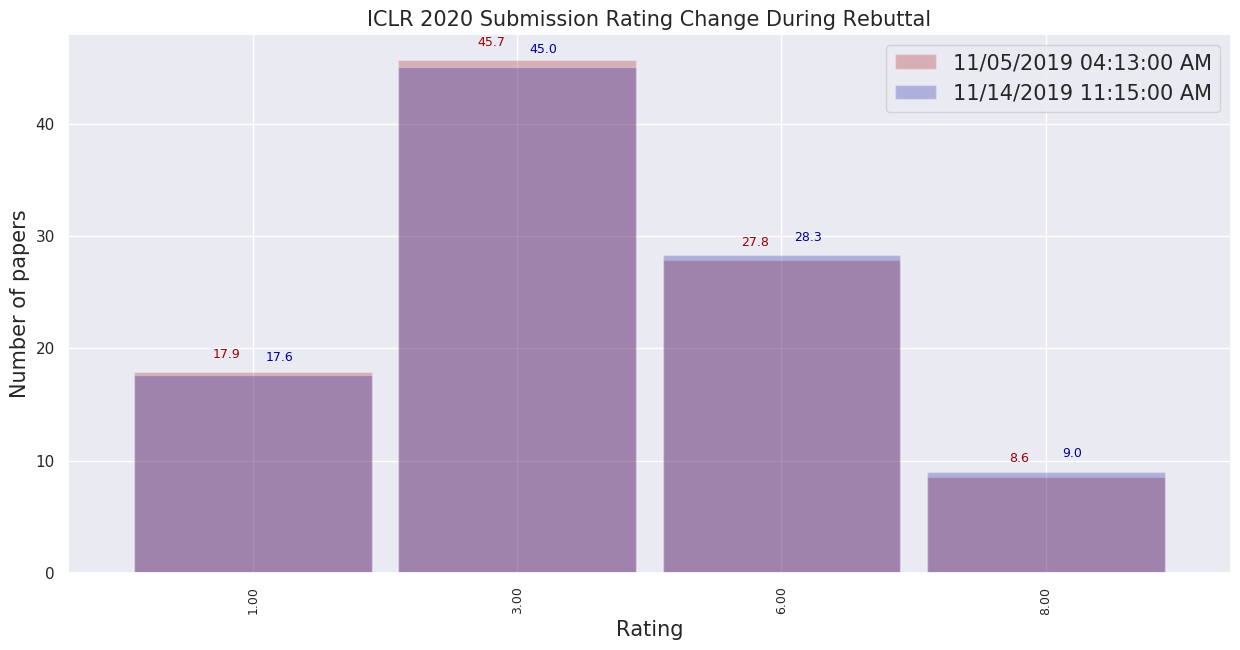

/home/walter/ENV/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
/home/walter/ENV/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.


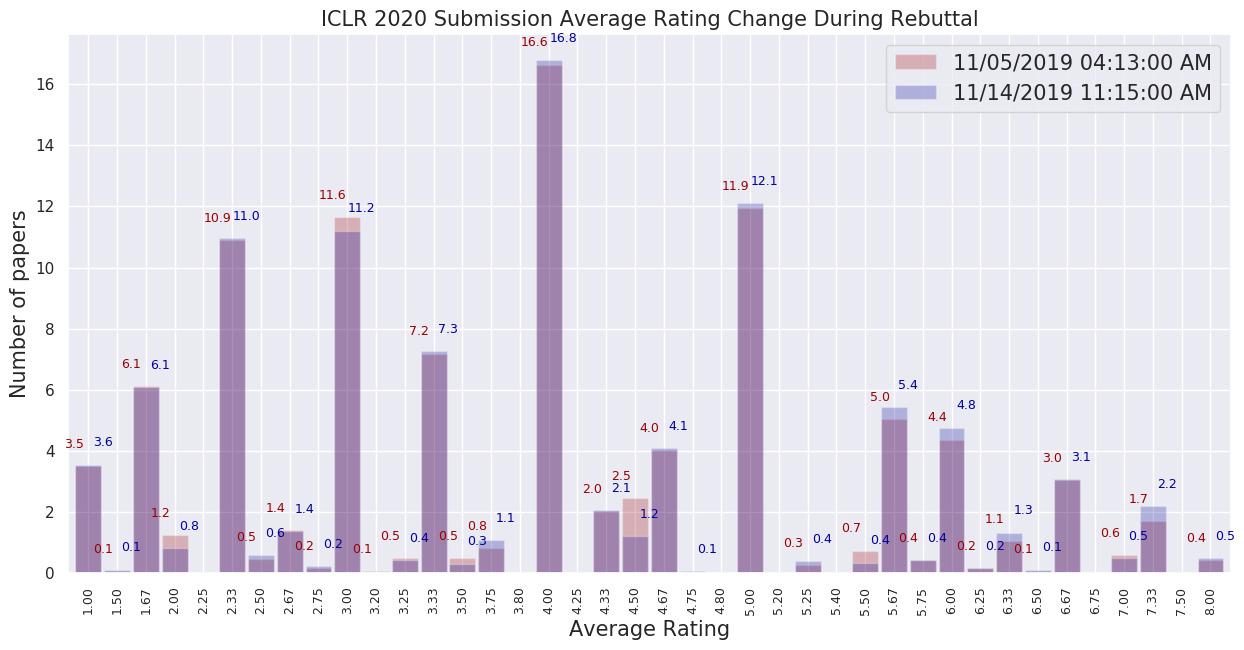

In [26]:
distribution_differet_plot(
    {'data': rating_1, 'legend': time1},
    {'data': rating_2, 'legend': time2},
    'ICLR 2020 Submission Rating Change During Rebuttal',
    'Rating',
    'Number of papers',
    'asset/rating_difference.png',
    legend_distance=0.1,
)        

distribution_differet_plot(
    {'data': rating_mean_1, 'legend': time1},
    {'data': rating_mean_2, 'legend': time2},
    'ICLR 2020 Submission Average Rating Change During Rebuttal',
    'Average Rating',
    'Number of papers',
    'asset/rating_mean_difference.png',
    legend_distance=0.5,    
    legend_height_offset=0.5,
)